<a href="https://colab.research.google.com/github/yongtangli/Neural_Manifolds/blob/main/Manifold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
# Remove cached module to force fresh import
if 'NMLfunc' in sys.modules:
    del sys.modules['NMLfunc']

import torch
import networkx as nx
import importlib

# If in Colab, clone repo or upload files
if IN_COLAB:
    # Clone from GitHub or upload files
    # For now, we'll assume files are in the same directory or uploaded
    import NMLfunc as nml
else:
    import NMLfunc as nml

# Force reload to get latest functions
importlib.reload(nml)

# Set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Build graph from barcodes
G, encoded_sequences = nml.build_barcode_graph('barcodes.tsv')

print(f"Graph created with {G.number_of_nodes()} nodes")
print(f"\nFirst 5 barcodes and their encodings:")
for node_id in range(5):
    barcode = G.nodes[node_id]['sequence']
    encoded = encoded_sequences[node_id]
    print(f"  {barcode} -> {encoded.tolist()}")


Using device: cpu
Graph created with 5697 nodes

First 5 barcodes and their encodings:
  AAACCCAAGGCGATAC-1 -> [0, 0, 0, 2, 2, 2, 0, 0, 3, 3, 2, 3, 0, 1, 0, 2]
  AAACCCAAGGCTGTAG-1 -> [0, 0, 0, 2, 2, 2, 0, 0, 3, 3, 2, 1, 3, 1, 0, 3]
  AAACCCACAAGTCCCG-1 -> [0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 3, 1, 2, 2, 2, 3]
  AAACCCACAGATGCGA-1 -> [0, 0, 0, 2, 2, 2, 0, 2, 0, 3, 0, 1, 3, 2, 3, 0]
  AAACCCACAGGTGAGT-1 -> [0, 0, 0, 2, 2, 2, 0, 2, 0, 3, 3, 1, 3, 0, 3, 1]


In [ ]:
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab")
    # Install required packages
    import subprocess
    subprocess.run(['pip', 'install', 'torch', 'networkx', '-q'], check=True)

    # Mount Google Drive (optional)
    from google.colab import drive
    drive.mount('/content/drive')

    # Check GPU availability
    import torch
    print(f"GPU Available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("Running locally (not in Google Colab)")


Running locally (not in Google Colab)


In [ ]:
import numpy as np
import torch
import os
from scipy import io
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt


In [ ]:
# Calculate pairwise distances between first 5 barcodes
print("Euclidean distances between first 5 barcodes (in R^16):\n")
for i in range(5):
    for j in range(i + 1, 5):
        barcode_i = G.nodes[i]['sequence']
        barcode_j = G.nodes[j]['sequence']
        encoded_i = encoded_sequences[i]
        encoded_j = encoded_sequences[j]
        dist = nml.euclidean_distance(encoded_i, encoded_j)
        print(f"Distance({barcode_i}, {barcode_j}): {dist:.4f}")


Euclidean distances between first 5 barcodes (in R^16):

Distance(AAACCCAAGGCGATAC-1, AAACCCAAGGCTGTAG-1): 3.7417
Distance(AAACCCAAGGCGATAC-1, AAACCCACAAGTCCCG-1): 6.0828
Distance(AAACCCAAGGCGATAC-1, AAACCCACAGATGCGA-1): 6.6332
Distance(AAACCCAAGGCGATAC-1, AAACCCACAGGTGAGT-1): 6.1644
Distance(AAACCCAAGGCTGTAG-1, AAACCCACAAGTCCCG-1): 5.3852
Distance(AAACCCAAGGCTGTAG-1, AAACCCACAGATGCGA-1): 6.0000
Distance(AAACCCAAGGCTGTAG-1, AAACCCACAGGTGAGT-1): 5.2915
Distance(AAACCCACAAGTCCCG-1, AAACCCACAGATGCGA-1): 5.3852
Distance(AAACCCACAAGTCCCG-1, AAACCCACAGGTGAGT-1): 4.3589
Distance(AAACCCACAGATGCGA-1, AAACCCACAGGTGAGT-1): 3.7417


In [ ]:
# Rebuild graph with edges based on distance threshold
# Only connect nodes with Euclidean distance <= 5.0
distance_threshold = 5.0
G_with_edges, _ = nml.build_barcode_graph('barcodes.tsv', add_edges=True, distance_threshold=distance_threshold)

print(f"\nGraph with edges (distance threshold = {distance_threshold}):")
print(f"  Nodes: {G_with_edges.number_of_nodes()}")
print(f"  Edges: {G_with_edges.number_of_edges()}")

# Show some edge examples with distances
if G_with_edges.number_of_edges() > 0:
    print(f"\nFirst 10 edges with distances:")
    for idx, (u, v, data) in enumerate(G_with_edges.edges(data=True)):
        if idx >= 10:
            break
        barcode_u = G_with_edges.nodes[u]['sequence']
        barcode_v = G_with_edges.nodes[v]['sequence']
        weight = data['weight']
        print(f"  {barcode_u} <-> {barcode_v}: {weight:.4f}")



Graph with edges (distance threshold = 5.0):
  Nodes: 5697
  Edges: 1827665

First 10 edges with distances:
  AAACCCAAGGCGATAC-1 <-> AAACCCAAGGCTGTAG-1: 3.7417
  AAACCCAAGGCGATAC-1 <-> AAACCCATCGATAACC-1: 3.8730
  AAACCCAAGGCGATAC-1 <-> AAACGCTAGCATCCTA-1: 4.5826
  AAACCCAAGGCGATAC-1 <-> AAACGCTAGGTACCTT-1: 4.3589
  AAACCCAAGGCGATAC-1 <-> AAACGCTGTCTTACTT-1: 4.8990
  AAACCCAAGGCGATAC-1 <-> AAACGCTTCTGCTTTA-1: 4.0000
  AAACCCAAGGCGATAC-1 <-> AAAGGGCAGGTTAGTA-1: 4.5826
  AAACCCAAGGCGATAC-1 <-> AAAGGTAAGACCATAA-1: 4.1231
  AAACCCAAGGCGATAC-1 <-> AAAGGTATCCTTCAGC-1: 5.0000
  AAACCCAAGGCGATAC-1 <-> AAAGGTATCGCTTTAT-1: 3.3166


In [ ]:
# Compute degree matrix, adjacency matrix, and Laplacian
print("Computing graph matrices...\n")

L, D, A = nml.compute_laplacian_matrix(G_with_edges)

print(f"Degree Matrix (D) shape: {D.shape}")
print(f"Adjacency Matrix (A) shape: {A.shape}")
print(f"Laplacian Matrix (L) shape: {L.shape}")

print(f"\nDegree Matrix (first 5x5):")
print(D[:5, :5])

print(f"\nAdjacency Matrix (first 5x5):")
print(A[:5, :5])

print(f"\nLaplacian Matrix (first 5x5):")
print(L[:5, :5])

# Compute eigenvalues of Laplacian (useful for spectral analysis)
eigenvalues, eigenvectors = torch.linalg.eigh(L)
print(f"\nLaplacian eigenvalues (first 10):")
print(eigenvalues[:10])

print(f"\nLaplacian eigenvectors shape: {eigenvectors.shape}")


Computing graph matrices...

Degree Matrix (D) shape: torch.Size([5697, 5697])
Adjacency Matrix (A) shape: torch.Size([5697, 5697])
Laplacian Matrix (L) shape: torch.Size([5697, 5697])

Degree Matrix (first 5x5):
tensor([[387.,   0.,   0.,   0.,   0.],
        [  0., 413.,   0.,   0.,   0.],
        [  0.,   0., 606.,   0.,   0.],
        [  0.,   0.,   0., 352.,   0.],
        [  0.,   0.,   0.,   0., 358.]])

Adjacency Matrix (first 5x5):
tensor([[0.0000, 3.7417, 0.0000, 0.0000, 0.0000],
        [3.7417, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 4.3589],
        [0.0000, 0.0000, 0.0000, 0.0000, 3.7417],
        [0.0000, 0.0000, 4.3589, 3.7417, 0.0000]])

Laplacian Matrix (first 5x5):
tensor([[387.0000,  -3.7417,   0.0000,   0.0000,   0.0000],
        [ -3.7417, 413.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000, 606.0000,   0.0000,  -4.3589],
        [  0.0000,   0.0000,   0.0000, 352.0000,  -3.7417],
        [  0.0000,   0.0000,  -4.

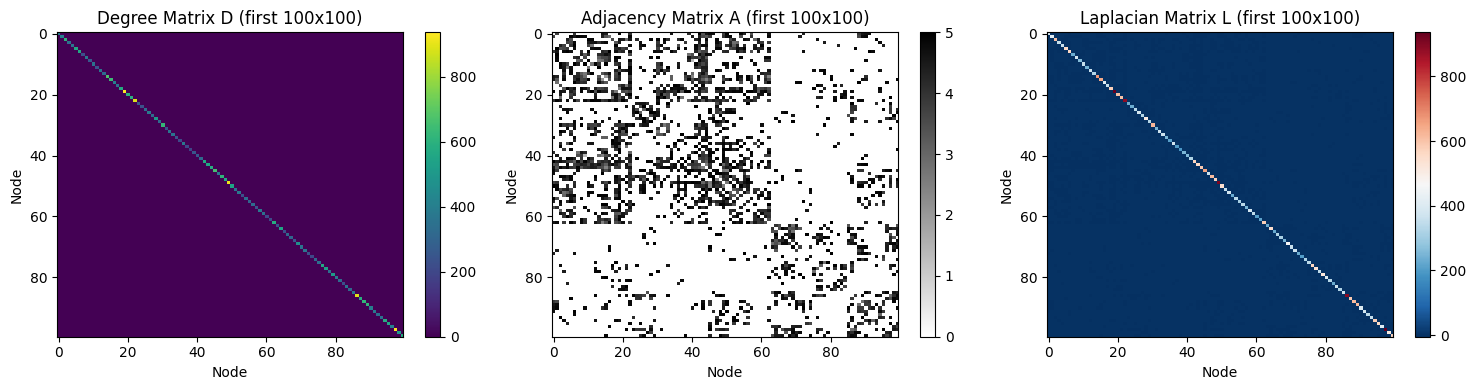

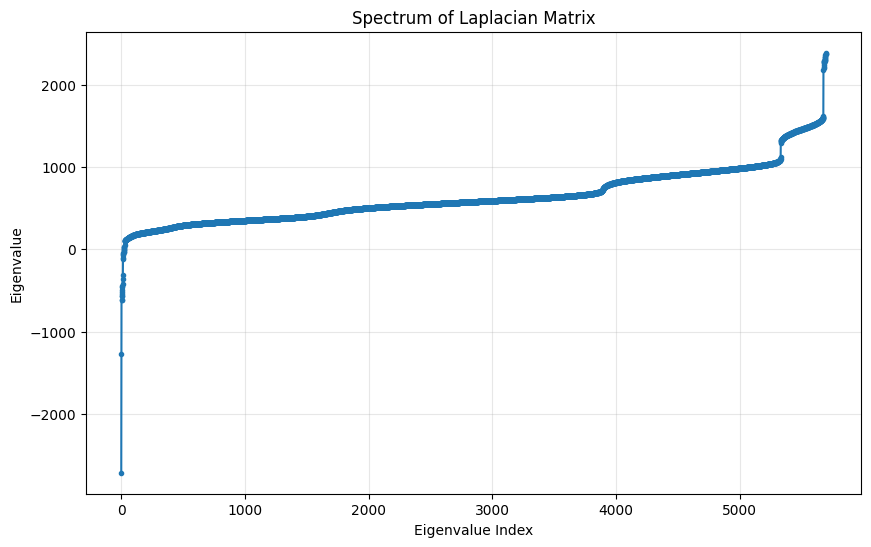


Laplacian Matrix Statistics:
  Min eigenvalue: -2715.200195
  Max eigenvalue: 2388.139893
  Sum of eigenvalues: 3655331.000000
  Number of zero eigenvalues (tolerance=1e-6): 0


In [ ]:
import matplotlib.pyplot as plt

# Visualize the matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Degree Matrix
im0 = axes[0].imshow(D[:100, :100].numpy(), cmap='viridis', aspect='auto')
axes[0].set_title('Degree Matrix D (first 100x100)')
axes[0].set_xlabel('Node')
axes[0].set_ylabel('Node')
plt.colorbar(im0, ax=axes[0])

# Adjacency Matrix
im1 = axes[1].imshow(A[:100, :100].numpy(), cmap='binary', aspect='auto')
axes[1].set_title('Adjacency Matrix A (first 100x100)')
axes[1].set_xlabel('Node')
axes[1].set_ylabel('Node')
plt.colorbar(im1, ax=axes[1])

# Laplacian Matrix
im2 = axes[2].imshow(L[:100, :100].numpy(), cmap='RdBu_r', aspect='auto')
axes[2].set_title('Laplacian Matrix L (first 100x100)')
axes[2].set_xlabel('Node')
axes[2].set_ylabel('Node')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

# Plot eigenvalue spectrum
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(eigenvalues.numpy(), 'o-', markersize=3)
ax.set_xlabel('Eigenvalue Index')
ax.set_ylabel('Eigenvalue')
ax.set_title('Spectrum of Laplacian Matrix')
ax.grid(True, alpha=0.3)
plt.show()

# Statistics
print(f"\nLaplacian Matrix Statistics:")
print(f"  Min eigenvalue: {eigenvalues.min():.6f}")
print(f"  Max eigenvalue: {eigenvalues.max():.6f}")
print(f"  Sum of eigenvalues: {eigenvalues.sum():.6f}")
print(f"  Number of zero eigenvalues (tolerance=1e-6): {(eigenvalues.abs() < 1e-6).sum().item()}")


In [ ]:
# Perform spectral embedding to reduce from 16D to 3D
importlib.reload(nml)

print("Performing spectral embedding (16D -> 3D)...\n")
embedding_3d, evals, evecs = nml.spectral_embedding(G_with_edges, n_components=3)

print(f"Original node dimension: 16 (DNA barcode)")
print(f"Embedded dimension: 3 (using Laplacian eigenvectors)")
print(f"Embedding shape: {embedding_3d.shape}")

# Normalize embedding for better visualization
embedding_3d_normalized = embedding_3d / (torch.norm(embedding_3d, dim=0, keepdim=True) + 1e-8)

print(f"\nEmbedding statistics:")
print(f"  Min: {embedding_3d.min():.4f}, Max: {embedding_3d.max():.4f}")
print(f"  Mean: {embedding_3d.mean():.4f}, Std: {embedding_3d.std():.4f}")

print(f"\nSmallest eigenvalues (first 5):")
print(evals[:5])


Performing spectral embedding (16D -> 3D)...

Original node dimension: 16 (DNA barcode)
Embedded dimension: 3 (using Laplacian eigenvectors)
Embedding shape: torch.Size([5697, 3])

Embedding statistics:
  Min: -0.0454, Max: 0.0431
  Mean: -0.0001, Std: 0.0132

Smallest eigenvalues (first 5):
tensor([-2715.2002, -1269.9498,  -617.5007,  -611.0292,  -570.9337])


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Extract 3D coordinates
x = embedding_3d[:, 0].numpy()
y = embedding_3d[:, 1].numpy()
z = embedding_3d[:, 2].numpy()

# Create 3D scatter plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot nodes colored by degree
degrees = [G_with_edges.degree(node) for node in range(G_with_edges.number_of_nodes())]
scatter = ax.scatter(x, y, z, c=degrees, cmap='viridis', s=20, alpha=0.6, edgecolors='k', linewidth=0.5)

# Plot edges
edges = G_with_edges.edges()
for u, v in edges:
    ax.plot([x[u], x[v]], [y[u], y[v]], [z[u], z[v]], 'gray', alpha=0.2, linewidth=0.5)

ax.set_xlabel('Eigenvector 1 (dim 0)')
ax.set_ylabel('Eigenvector 2 (dim 1)')
ax.set_zlabel('Eigenvector 3 (dim 2)')
ax.set_title('3D Graph Embedding using Spectral Embedding\n(16D DNA barcodes reduced to 3D via Laplacian eigenvectors)')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
cbar.set_label('Node Degree')

plt.tight_layout()
plt.show()

print(f"3D embedding visualization created!")
print(f"  Total nodes: {len(x)}")
print(f"  Total edges: {G_with_edges.number_of_edges()}")
